In [65]:
!pip install -r "requirements.txt"

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = None

In [45]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
pokemon = pd.read_csv("./pokemon.csv", index_col="#")

In [46]:
train

,Winner,First_pokemon,Second_pokemon
0,44,28,44
1,466,126,466
2,410,410,532
3,496,474,496
4,699,699,458
...,...,...,...
31995,40,40,708
31996,496,496,762
31997,770,763,770
31998,490,490,698


# Analisi
Tutte le considerazioni sono relative al dataset di training corrente, con un altro dataset questi valori potrebbero variare.

In [47]:
train.dtypes

Winner            int64
First_pokemon     int64
Second_pokemon    int64
dtype: object

In [48]:
pokemon.dtypes

Name          object
Type 1        object
Type 2        object
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

## Valori mancanti / nulli

In [49]:
pokemon.isnull().sum()

Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [50]:
train.isnull().sum()

Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64

In [51]:
print(f"Missing (type 2) { len(pokemon[pokemon['Type 2'].isnull()]) / len(pokemon.index) * 100 }% ")

Missing (type 2) 48.25% 


### Considerazioni
- E' presente un Pokemon con un nome mancante
- 386 Pokemon non hanno un tipo 2 (48,25% nel corrente dataset di training). Questo vuol dire che non abbiamo informazioni sul secondo tipo per la metà dei pokemon rimanenti. Probabilmente questa colonna dovrà essere droppata, in quanto non abbiamo modo di sostituirla, fare un replace con il tipo 2 più frequente non avrebbe senso, nè tantomeno creare un nuovo valore ad hoc tramite encoding.

## Percentuale di vincita
Viene definita la percentuale di vincita per ogni pokemon, allo scopo di poter analizzare come varia in base alle altre features.

In [52]:
len(train[train['Winner'] == 2])

31

In [53]:
winner_count = train.groupby("Winner").count()
winner_count

,First_pokemon,Second_pokemon
Winner,,
1,28,28
2,31,31
3,55,55
4,53,53
5,36,36
...,...,...
796,21,21
797,78,78
798,39,39


In [54]:
first_pokemon_count = train.groupby("First_pokemon").count()
second_pokemon_count = train.groupby("Second_pokemon").count()
total_combats = first_pokemon_count['Winner'] + second_pokemon_count['Winner']

In [55]:
winner_count = train.groupby("Winner").count()
win_percentage = winner_count['First_pokemon'] / total_combats * 100
pokemon['win_percentage'] = win_percentage

## Analisi Feature "Type 1"
La tipologia determina la probabilità di vincita, pokemon di tipo "flying", "dragon", "dark", nel training set hanno vinto più volte in percentuale. Sembra esserci una correlazione tra il tipo e la percentuale di vittorie. In realtà dal grafico sotto si può vedere che questa derivi da altre caratteristiche. Type 1 quindi è ridondante.

<AxesSubplot:xlabel='Type 1', ylabel='win_percentage'>

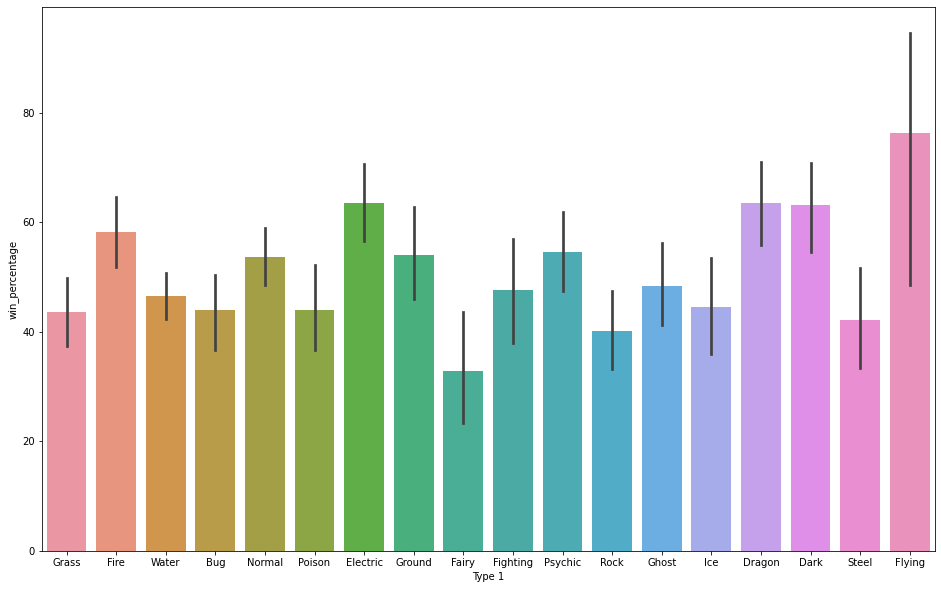

In [56]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Type 1", y="win_percentage", data=pokemon)

<AxesSubplot:xlabel='Type 1', ylabel='Speed'>

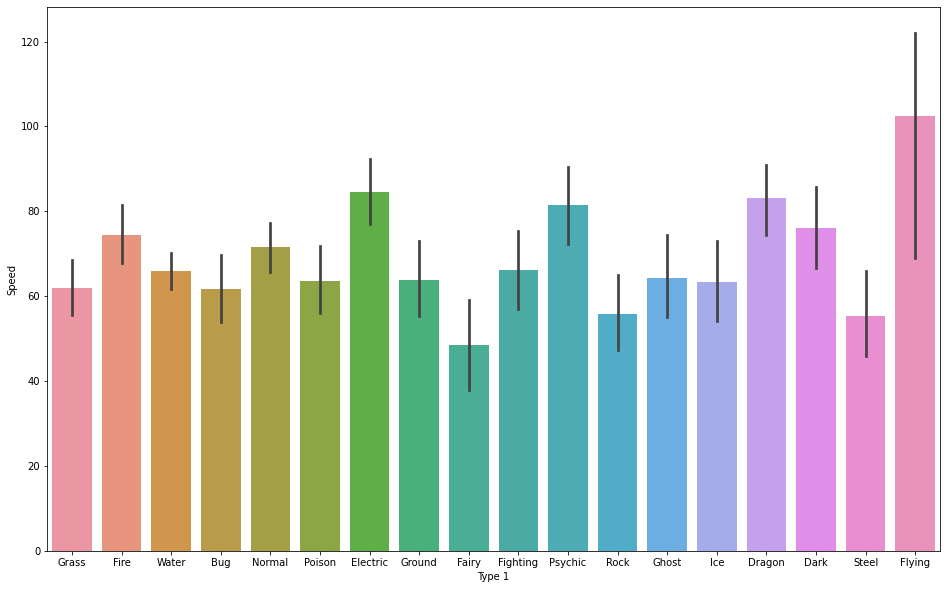

In [63]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Type 1", y="Speed", data=pokemon)

## Analisi Feature "Speed"
E' presente un trend positivo, all'aumentare della "speed" aumenta la percentuale di vittoria. Speed è probabilmente una feature molto importante.

<AxesSubplot:xlabel='Speed', ylabel='win_percentage'>

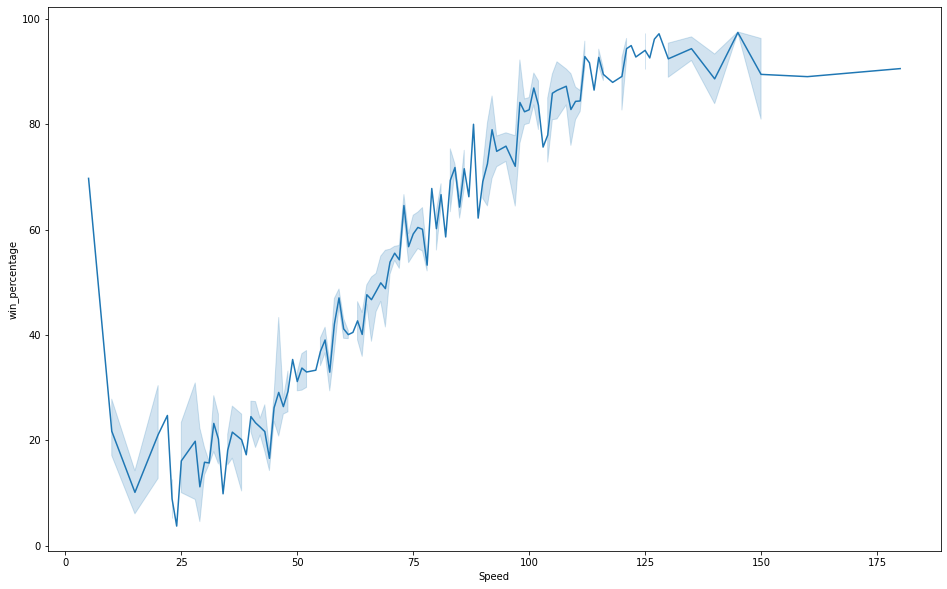

In [57]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Speed", y="win_percentage", data=pokemon)

## Analisi feature "Attack"
Anche la feature "attack" presenta una forte relazione con la percentuale di vittoria, sebbene presenti molte oscillazioni.

<AxesSubplot:xlabel='Attack', ylabel='win_percentage'>

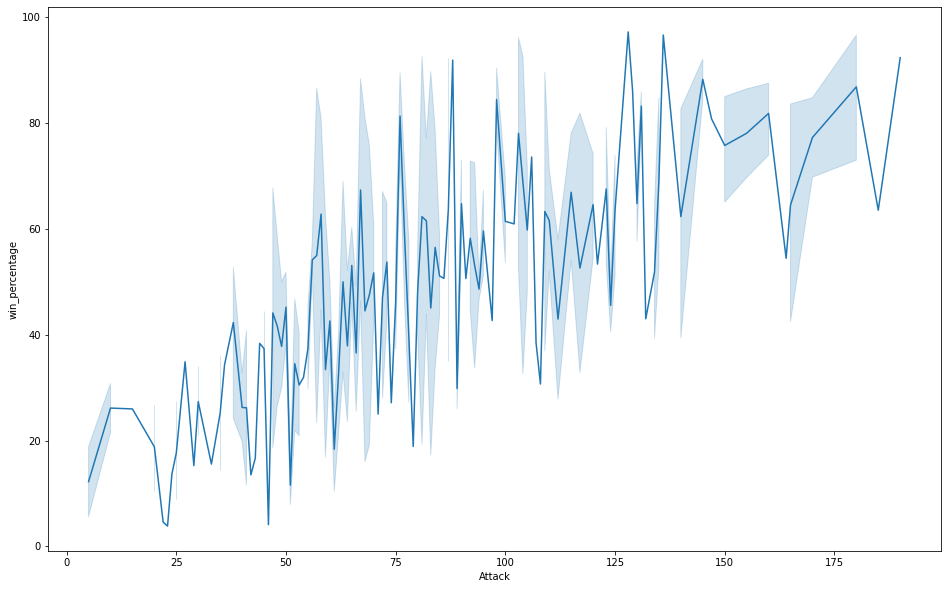

In [58]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Attack", y="win_percentage", data=pokemon)

## Analisi Feature "Defense"
La feature "Defense" sembra abbastanza randomica, presenta infatti un line chart ricco di oscillazioni

<AxesSubplot:xlabel='Defense', ylabel='win_percentage'>

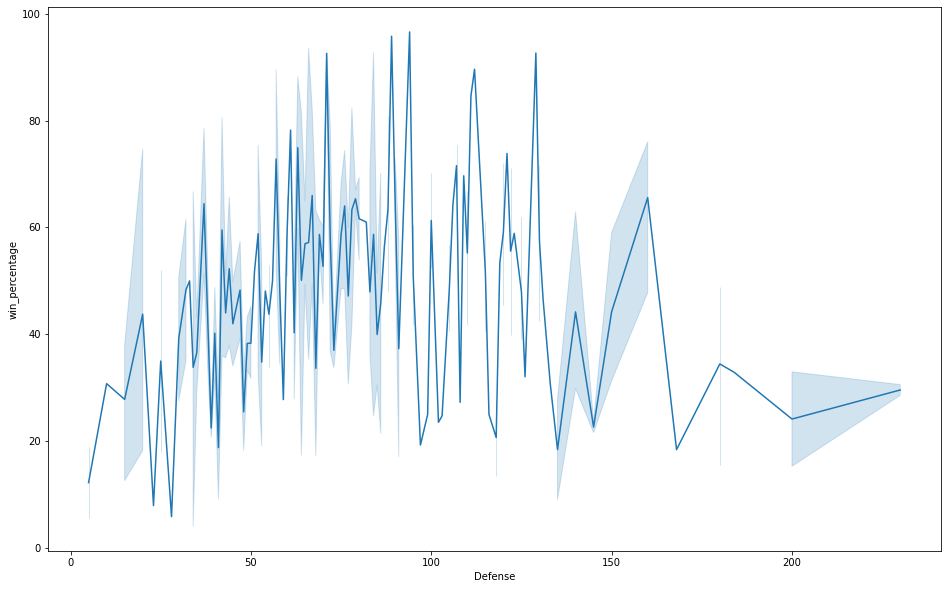

In [59]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Defense", y="win_percentage", data=pokemon)

## Analisi Feature "Generation"
La feature "Generation" presenta delle percentuali di vittoria molto simili tra di loro, pertanto è probaiblmente superfluea.

<AxesSubplot:xlabel='Generation', ylabel='win_percentage'>

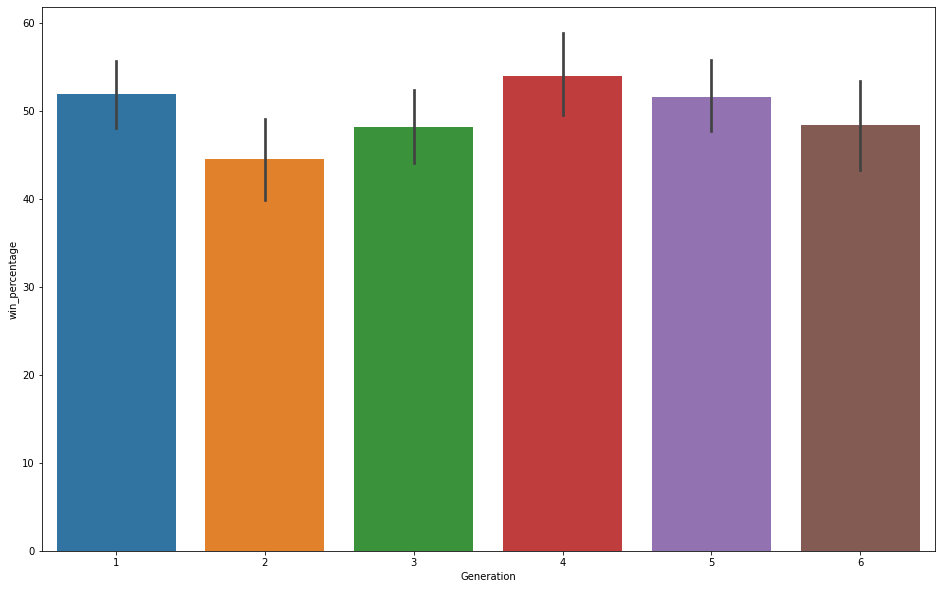

In [60]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Generation", y="win_percentage", data=pokemon)

## Analisi Feature "Legendary"
La feature "Legendary" risulta essere piuttosto determinante per le probabilità di vittoria.

<AxesSubplot:xlabel='Legendary', ylabel='win_percentage'>

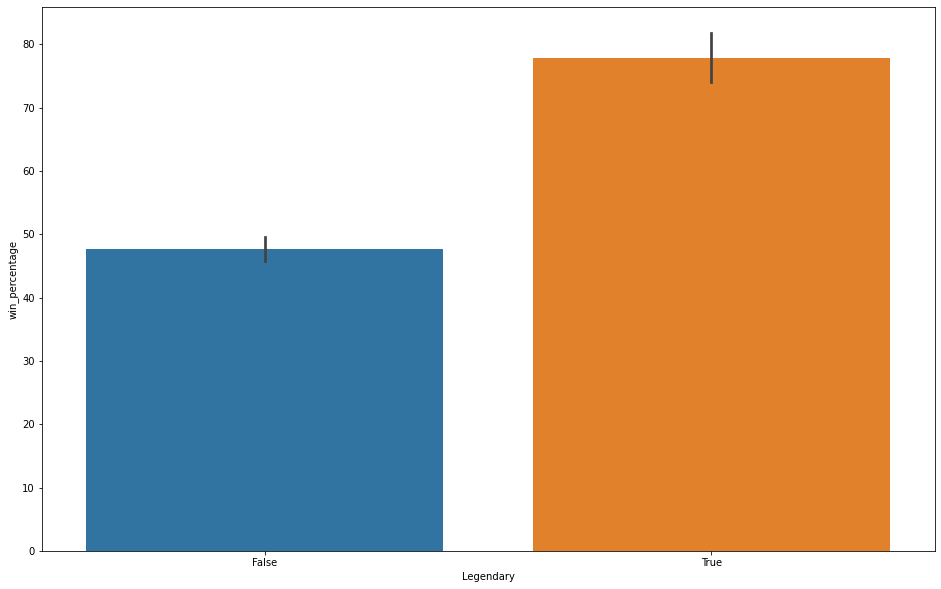

In [61]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Legendary", y="win_percentage", data=pokemon)

<AxesSubplot:xlabel='Type 1', ylabel='win_percentage'>

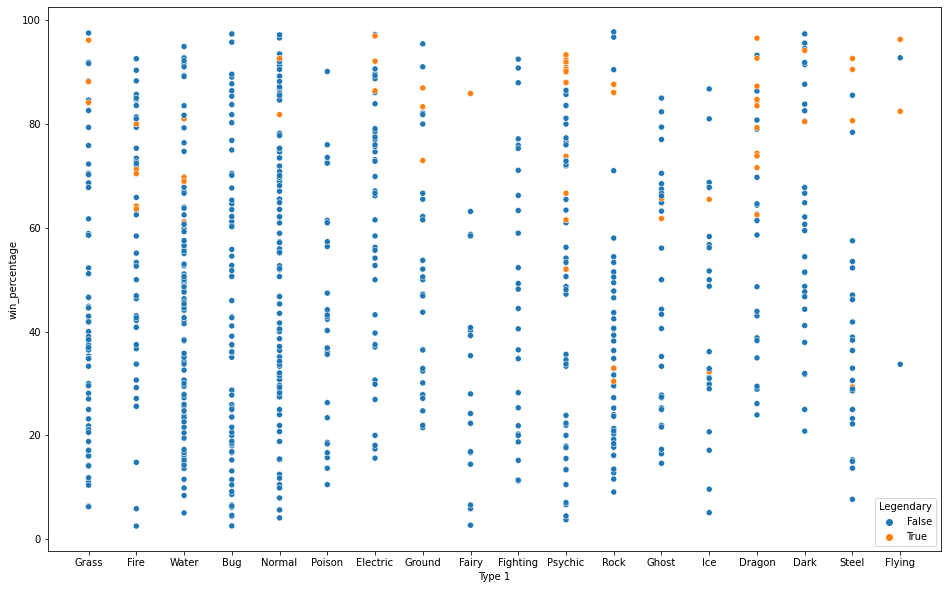

In [20]:
plt.figure(figsize=(16, 10))
sns.scatterplot(hue="Legendary", x="Type 1", y="win_percentage", data=pokemon)

### Analisi Feature "Speed Defense"

<AxesSubplot:xlabel='Sp. Def', ylabel='win_percentage'>

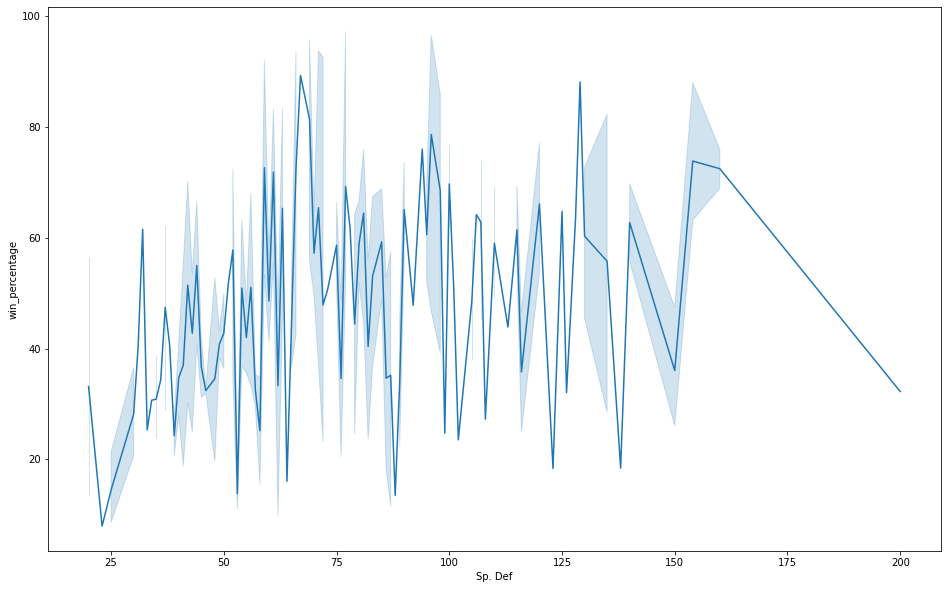

In [21]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Sp. Def", y="win_percentage", data=pokemon)

## Correlazione
### Considerazioni
- La feature "Generation" ha una correlazione con "Win_percentage" piuttosto bassa. Dato anche il grafico sopra si tratta probabilmente di una feature superfluea.

<AxesSubplot:>

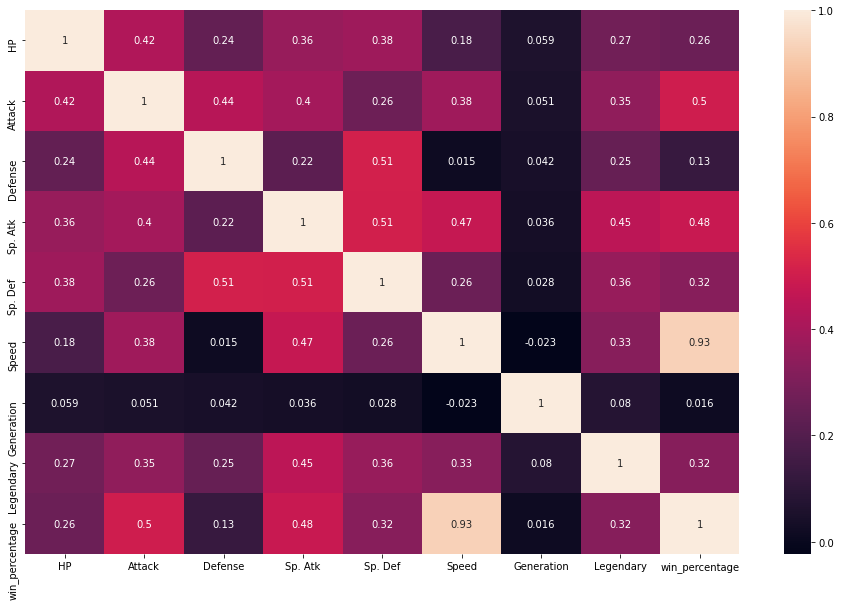

In [22]:
corr = pokemon.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(data=corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

In [23]:
pokemon.drop(columns='win_percentage', inplace=True)

# Preprocessing

In [24]:
pokemon.drop(columns='Name', inplace=True)

Definiamo una funzione di utilità che converte la nostra colonna target, vogliamo predirre se sarà il primo o il secondo pokemon nella battaglia a vincere. Perciò Winner andrà ad indicare 1/2 chi ha vinto in base alla posizione.

In [25]:
def convertTarget(_df):
    df = _df.copy()
    df['Winner'] = (df['Winner'] == df['First_pokemon']).map(lambda el: 1 if el else 2)
    return df


In [26]:
train = convertTarget(train)
test = convertTarget(test)

In [27]:
pokemon.Legendary = pokemon.Legendary.map(lambda el: 1 if el else 0)

In [28]:
pokemon.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,
1,Grass,Poison,45,49,49,65,65,45,1,0
2,Grass,Poison,60,62,63,80,80,60,1,0
3,Grass,Poison,80,82,83,100,100,80,1,0
4,Grass,Poison,80,100,123,122,120,80,1,0
5,Fire,NaN,39,52,43,60,50,65,1,0


### Join
Facciamo un multijoin, unendo i dati riguardanti le statistiche del primo combattente e del secondo.

In [29]:
def mergePokemonsData(df):
    full_data = pd.merge(df, pokemon.add_prefix("First_pokemon_"), how="left", left_on=['First_pokemon'], right_index=True)
    full_data = pd.merge(full_data, pokemon.add_prefix("Second_pokemon_"), how="left", left_on=['Second_pokemon'],  right_index=True)
    full_data.drop(columns=['First_pokemon', 'Second_pokemon'], inplace=True)
    return full_data

In [30]:
full_train_data = mergePokemonsData(train)
full_test_data = mergePokemonsData(test)
full_train_data

,Winner,First_pokemon_Type 1,First_pokemon_Type 2,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Defense,First_pokemon_Sp. Atk,First_pokemon_Sp. Def,First_pokemon_Speed,First_pokemon_Generation,First_pokemon_Legendary,Second_pokemon_Type 1,Second_pokemon_Type 2,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Defense,Second_pokemon_Sp. Atk,Second_pokemon_Sp. Def,Second_pokemon_Speed,Second_pokemon_Generation,Second_pokemon_Legendary
0,2,Normal,Flying,65,90,65,61,61,100,1,0,Fire,NaN,73,76,75,81,100,100,1,0
1,2,Water,NaN,30,40,70,70,25,60,1,0,Water,NaN,55,65,35,60,30,85,4,0
2,1,Dragon,Flying,95,145,130,120,90,120,3,0,Electric,Ghost,50,50,77,95,77,91,4,0
3,2,Ghost,Flying,150,80,44,90,54,80,4,0,Normal,NaN,135,85,40,40,85,5,4,0
4,1,Bug,Fire,85,60,65,135,105,100,5,0,Bug,NaN,40,29,45,29,45,36,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,1,Poison,Ground,81,102,77,85,75,85,1,0,Dragon,Electric,100,150,120,120,100,90,5,1
31996,1,Normal,NaN,135,85,40,40,85,5,4,0,Poison,Dragon,65,75,90,97,123,44,6,0
31997,2,Water,NaN,50,53,62,58,63,44,6,0,Rock,Ice,123,77,72,99,92,58,6,0
31998,1,Normal,Flying,76,65,45,92,42,91,4,0,Bug,Fire,55,85,55,50,55,60,5,0


### Encoding
Effettiamo un label encoding delle colonne categoriche.

In [31]:
encoder = LabelEncoder()
categorical_cols = ['First_pokemon_Type 1', 'Second_pokemon_Type 1', "First_pokemon_Type 2", "Second_pokemon_Type 2"]
for col in categorical_cols:
    try:
        full_train_data[col] = encoder.fit_transform(full_train_data[col])
        full_test_data[col] = encoder.fit_transform(full_test_data[col])
    except:
        continue

In [32]:
full_train_data

,Winner,First_pokemon_Type 1,First_pokemon_Type 2,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Defense,First_pokemon_Sp. Atk,First_pokemon_Sp. Def,First_pokemon_Speed,First_pokemon_Generation,First_pokemon_Legendary,Second_pokemon_Type 1,Second_pokemon_Type 2,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Defense,Second_pokemon_Sp. Atk,Second_pokemon_Sp. Def,Second_pokemon_Speed,Second_pokemon_Generation,Second_pokemon_Legendary
0,2,12,7,65,90,65,61,61,100,1,0,6,18,73,76,75,81,100,100,1,0
1,2,17,18,30,40,70,70,25,60,1,0,17,18,55,65,35,60,30,85,4,0
2,1,2,7,95,145,130,120,90,120,3,0,3,8,50,50,77,95,77,91,4,0
3,2,8,7,150,80,44,90,54,80,4,0,12,18,135,85,40,40,85,5,4,0
4,1,0,6,85,60,65,135,105,100,5,0,0,18,40,29,45,29,45,36,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,1,13,10,81,102,77,85,75,85,1,0,2,3,100,150,120,120,100,90,5,1
31996,1,12,18,135,85,40,40,85,5,4,0,13,2,65,75,90,97,123,44,6,0
31997,2,17,18,50,53,62,58,63,44,6,0,15,11,123,77,72,99,92,58,6,0
31998,1,12,7,76,65,45,92,42,91,4,0,0,6,55,85,55,50,55,60,5,0


## Correlazione
Utilizzo la Correlazione dopo aver effettuato il merge, per confermare le ipotesi fatte durante l'analisi

<AxesSubplot:>

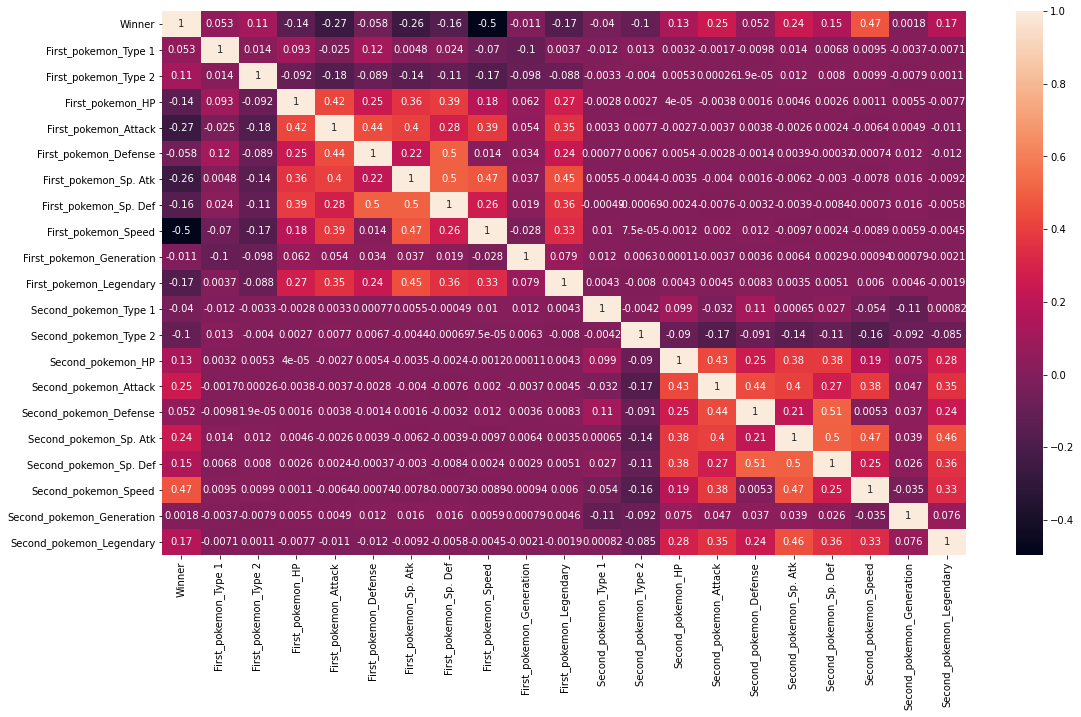

In [33]:
corr = full_train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

Droppiamo le colonne superflue in base all'analisi effettuata.

In [34]:
columns_to_drop = ['First_pokemon_Generation', "First_pokemon_Type 1", "First_pokemon_Type 2", "First_pokemon_Defense", "First_pokemon_Sp. Def", "Second_pokemon_Generation", "Second_pokemon_Type 1", "Second_pokemon_Type 2", "Second_pokemon_Defense", "Second_pokemon_Sp. Def"]
for col in columns_to_drop:
    try:
        full_train_data = full_train_data.drop(columns=col)
        full_test_data = full_test_data.drop(columns=col)
    except:
        continue

In [35]:
X_train = full_train_data.drop(columns=['Winner'])
y_train = full_train_data.Winner

X_test = full_test_data.drop(columns='Winner')
y_test = full_test_data.Winner
X_train

,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Sp. Atk,First_pokemon_Speed,First_pokemon_Legendary,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Sp. Atk,Second_pokemon_Speed,Second_pokemon_Legendary
0,65,90,61,100,0,73,76,81,100,0
1,30,40,70,60,0,55,65,60,85,0
2,95,145,120,120,0,50,50,95,91,0
3,150,80,90,80,0,135,85,40,5,0
4,85,60,135,100,0,40,29,29,36,0
...,...,...,...,...,...,...,...,...,...,...
31995,81,102,85,85,0,100,150,120,90,1
31996,135,85,40,5,0,65,75,97,44,0
31997,50,53,58,44,0,123,77,99,58,0
31998,76,65,92,91,0,55,85,50,60,0


# Addestramento

Utilizzo il classificatore di tipo RandomForest, il quale utilizza un approccio basato su più alberi di decisione. Su questo dataset performa meglio di DecisionTree.

In [36]:
model = RandomForestClassifier(random_state=20)
model.fit(X_train, y_train)

print("Trained!")

Trained!


# Accuracy

In [66]:
train_score = model.score(X_train, y_train)
print(f"Train set score: {round(train_score * 100, 5) }%")

Train set score: 99.99688%


In [67]:
test_score = model.score(X_test, y_test)
print(f"Test set score: {round(test_score  * 100, 5)}%")

Test set score: 94.8%
